# DISummit 2018 - Introduction to text mining
<img src="XploData_logo.png" width = "40%">
<br>
Powered by [XploData](https://www.xplodata.be/)

## Introduction

Text mining is a general term to retreive information from large quantities of text. What can be done by hand (reading a text, knowing what it is about, determining keywords, associating with other texts...) can to some extent also be done my using machine learning algorithms, be it much faster. In this hands-on Python workshop, we will introduce you to some of the text mining principles that are used to achieve this.

In the context of the [HIV Hackathon](https://hivhack.org/), organized by Digityser in September 2018, we will focus on a [public available PDF](http://phia.icap.columbia.edu/wp-content/uploads/2017/11/Tanzania_SummarySheet_A4.English.v19.pdf) related to HIV in Tanzania. Although the PDF contains multiple types of data, the scope of this workshop will be limited to the actual text itself. 
*As a side note, alternatively text can be extracted from images using [OCR](https://en.wikipedia.org/wiki/Optical_character_recognition).*

Before we can start with text mining, we need to acquire the text from our PDF into Python.
Fortunately, multiple Python libraries exist, but we will use the popular PyPDF2 package.
For flexibility reasons, we will also introduce the XpdfReader toolkit.

## Importing data
### Extracting text with a python library
e.g.: [PyPDF2](https://pypi.org/project/PyPDF2/)

In [1]:
import PyPDF2

# creating an object 
file = open(r'..\data\HIV\Tanzania_SummarySheet_English.pdf', 'rb')

# creating a pdf reader object
fileReader = PyPDF2.PdfFileReader(file)

# print the number of pages in pdf file
print(fileReader.numPages)
print()

# print text on last page
print(fileReader.pages[-1].extractText())

# close the file-stream
file.close()

ModuleNotFoundError: No module named 'PyPDF2'

Disadvantages:
    - no control over character encodings
    - no image extraction

### Extracting text with an external toolkit
e.g.: [PDFTOTEXT (XpdfReader)](http://www.xpdfreader.com/)

The commandline can be accessed using the `subprocess` standard library.

In [9]:
import subprocess

# define file paths
in_file = r'..\data\HIV\Tanzania_SummarySheet_English.pdf'
txt_file = r'..\output\output_txt\utf8_encoded.txt'

# make and execute command to convert to txt using UTF-8 encoding for resulting txt file
pdf_txt_command = ["pdftotext", "-enc", "UTF-8", in_file, txt_file]
subprocess.run(pdf_txt_command, shell=True)

CompletedProcess(args=['pdftotext', '-enc', 'UTF-8', '..\\data\\HIV\\Tanzania_SummarySheet_English.pdf', '..\\output\\output_txt\\utf8_encoded.txt'], returncode=1)

In [3]:
# We can now open the textfile with the specified encoding
with open(txt_file, mode='rt', encoding='utf-8') as file:
    print(file.read()[-900:])

 important national and regional HIV-related parameters, including progress toward 90-90-90 goals, and will guide policy and funding priorities. ICAP at Columbia University is implementing the PHIA Project in close collaboration with CDC and other partners. See phia.icap.columbia.edu for more details.
The mark “CDC” is owned by the US Dept. of Health and Human Services and is used with permission. Use of this logo is not an endorsement by HHS or CDC of any particular product, service, or enterprise. This project is supported by the U.S. President’s Emergency Plan for AIDS Relief (PEPFAR) through CDC under the terms of cooperative agreement #U2GGH001226. The ﬁndings and conclusions in this report are those of the authors and do not necessarily represent the ofﬁcial position of the funding agencies. The results presented should be considered preliminary and they are subject to change.
6




You noticed that we used the argument 'UTF-8' for the encoding parameter. Variable width character encoding is used to represent a repertoire of characters by an encoding system (more on that [here](https://en.wikipedia.org/wiki/Character_encoding)). UTF-8 is one of the most common used encoding since 2009, but if you're not sure of the character encoding in the pdf-file you can choose to not specify it during our conversion and make a *guess* later.
We can use the `chardet` package for *guessing* character encodings.

In [4]:
# define file paths
in_file = r'..\data\HIV\Tanzania_SummarySheet_English.pdf'
txt_file = r'..\output\output_txt\guess_encoding.txt'

# make and execute command to convert to txt, without specifying an encoding
pdf_txt_command = ["pdftotext", in_file, txt_file]
subprocess.run(pdf_txt_command, shell=True)

CompletedProcess(args=['pdftotext', '..\\data\\HIV\\Tanzania_SummarySheet_English.pdf', '..\\output\\output_txt\\guess_encoding.txt'], returncode=0)

In [5]:
import chardet

# read file as bytes
with open(txt_file, mode='rb') as byte_file:
    raw_input = byte_file.read()

# guess encoding
encodings = chardet.detect(raw_input)
print(encodings)

{'encoding': 'ISO-8859-1', 'confidence': 0.73, 'language': ''}


In [6]:
# decode bytes to string
text = raw_input.decode('8859')
print(text[-900:])

tant national and regional HIV-related parameters, including progress toward 90-90-90 goals, and will guide policy and funding priorities. ICAP at Columbia University is implementing the PHIA Project in close collaboration with CDC and other partners. See phia.icap.columbia.edu for more details.
The mark "CDC" is owned by the US Dept. of Health and Human Services and is used with permission. Use of this logo is not an endorsement by HHS or CDC of any particular product, service, or enterprise. This project is supported by the U.S. President's Emergency Plan for AIDS Relief (PEPFAR) through CDC under the terms of cooperative agreement #U2GGH001226. The findings and conclusions in this report are those of the authors and do not necessarily represent the official position of the funding agencies. The results presented should be considered preliminary and they are subject to change.
6




We will continue the rest of the examples with the `ISO-8859-1` decoded text.

For more info on supported codecs, visit the python [docs](https://docs.python.org/3/library/codecs.html#standard-encodings)

### Extracting images from a PDF
#### Using  [PDFIMAGES](http://www.xpdfreader.com/)

PDFimages comes from the same toolkit as pdftotext and we also call it using the `subprocess` package.

In [7]:
import os

# define file paths
in_file = r'..\data\HIV\Tanzania_SummarySheet_English.pdf'
images = r'..\output\output_img'

# extract images
pdf_img_command = ["pdfimages", "-j", in_file, images + r'\img']
subprocess.run(pdf_img_command, shell=True)

CompletedProcess(args=['pdfimages', '-j', '..\\data\\HIV\\Tanzania_SummarySheet_English.pdf', '..\\output\\output_img\\img'], returncode=0)

You might notice that a lot of the extracted images are in a ppm or similar format, which few programs can easily work with.
A usefull toolkit for working with images is [imagemagick](https://www.imagemagick.org/script/index.php).

### Language detection
A human capable of reading is able to distinguish between his mother tongue and a foreign language. We perceive this by reading language specific words, grammatical constructions, context... Language detection in Python is quite straightforward and is performed using the `langdetect` package.

In [2]:
from langdetect import detect

language = detect(text)
print(language)

ModuleNotFoundError: No module named 'langdetect'

## Data preprocessing
Until this point, you were mainly preparing the data, i.e. converting the pdf to text and analyzing some meta-data.
The next critical step in text mining is preprocessing. This process involves different techniques (for an overview, see [here](https://pdfs.semanticscholar.org/1fa1/1c4de09b86a05062127c68a7662e3ba53251.pdf)), of which we will cover **tokenization, part-of-speech tagging, stop word removal, stemming and lemmatization**.
### Wordclouds and bar charts
To get insights of the contents of a text file, various visualisations are possible. Frequently used ones are wordclouds and bar charts, and will be used to demonstrate the differenct aspects of text mining preprocessing.

*Since we will often repeat the same visualisation during this workshop, we prepared a custom function.*

In [36]:
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# instantiate wordcloud
wordcloud = WordCloud(  background_color='white',
                        max_words=50,
                        max_font_size=80, 
                        random_state=42,
                        collocations=False)

def gen_wc_barh(tokens, amount=9):
    """
    Generate a wordcloud from the provided tokens.
    Generate a horizontal bar graph from the top #amount tokens.
    Show both vizualizations.
    """
    ctr = Counter(tokens)
    # generate wc from the counted tokens
    wordcloud.generate_from_frequencies(dict(ctr))
    plt.figure(1)
    plt.imshow(wordcloud)
    plt.axis('off')
    
    # generate barh from counted tokens
    tokens, weights = zip(*ctr.most_common(amount))
    plt.figure(2)
    plt.barh(tokens, weights)

    # show graphs
    plt.show()
    

To demonstrate the importance of preprocessing, we will generate a visualisation after each preprocessing step, whereafter you can evaluate the effect. For starters, we build our first visual on the *unpreprocessed* text, to get a feeling of what a wordcloud can tell you about the contents of a text file.

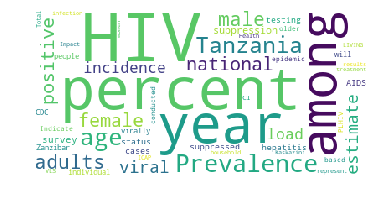

In [21]:
# generate from unprocessed input text
wordcloud.generate_from_text(text)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Notice how frequent occurring words are displayed in a larger font size, but these are not necessarily the most important ones (e.g. percent, year, among). You can improve this, let’s do this step by step.

### Tokenization
[Tokenization]( https://en.wikipedia.org/wiki/Lexical_analysis#Tokenization) is the process of cutting the text files in individual ‘tokens’. These can be words, but also numbers, punctuation marks or symbols, but don’t worry for that now. You’ll need an additional package for this, called the "Natural Language Toolkit": `nltk`

In [9]:
import nltk

# break text up into smaller bits -> tokens
# First, split the text up in sentences
sentences = nltk.sent_tokenize(text)
# Then we further split each sentence into tokens
tokenized_sentences = [nltk.word_tokenize(sentence) for sentence in sentences]


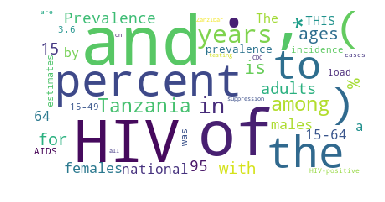

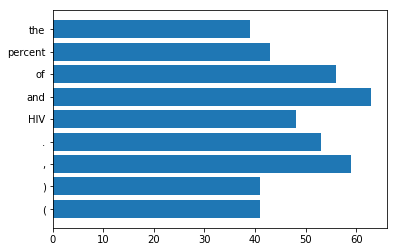

In [37]:
# concatenate all the tokenized sentences into a single list
gen_wc_barh([token for sent in tokenized_sentences for token in sent])

As predicted, you can see that the extracted tokens resulted in more than just 'words'. What do you think was used as delimiter (or separator) for splitting up the tokens?

### Part-of-Speech tagging
To increase the value of our freshly extracted tokens, we can assign labels/tags to them. As a result, each token is given a grammatical meaning. This process is called [Part-Of-Speech (POS) tagging](https://en.wikipedia.org/wiki/Part-of-speech_tagging). The ‘tagging’ is based on a previously trained model, which we can also call from the `nltk` package. The default tags generated by `nltk` can be found [here](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html).

In [19]:
# We use the model built into NLTK to assign grammatical meaning to our tokens -> POS tags
tagged_sentences = [nltk.pos_tag(sentence) for sentence in tokenized_sentences]
print("Example tagged sentence:")
print(tagged_sentences[42])

Example tagged sentence:
[('Survey', 'NNP'), ('weights', 'NNS'), ('are', 'VBP'), ('utilized', 'VBN'), ('for', 'IN'), ('all', 'DT'), ('estimates', 'NNS'), ('.', '.')]


When visualizing our text, we usually aren't interested in all types of tokens. For our usecase we are interested in discovering the topics of our text, so we are more interested in 'word-like' tokens.

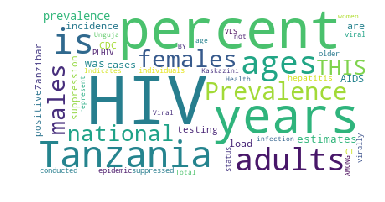

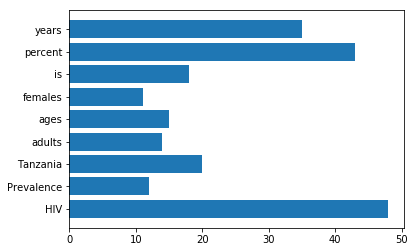

In [38]:
# determine which tokens we want to consider
# shorthand POS tag lists:
adj = ['JJ', 'JJR', 'JJS']
noun = ['NN', 'NNS', 'NNP', 'NNPS']
adverb = ['RB', 'RBR', 'RBS']
verb = ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']

# interesting tokens
tokens = [(token, tag)\
            for sentence in tagged_sentences\
            for (token, tag) in sentence\
            if token.isalpha()\
            and tag in adj + noun + adverb + verb]

# extract the 'token-values' from the tagged sentences
gen_wc_barh([token for (token, tag) in tokens])

Note that the tagging is not always ‘sure’ about the meaning of a word. Could you determine which (of the) word(s) in the above bar chart has/have multiple tagging possibilities?

### Stop words removal
Spoken languages contain a lot of (small) words that usually don't add extra meaning to a sentence (how many stop words are in this sentence?). To better understand the content of a text, you want to filter out those stop words.

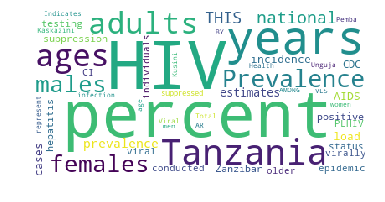

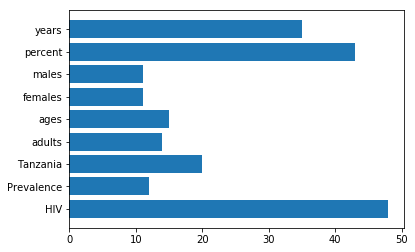

In [39]:
from nltk.corpus import stopwords
# filter out the english stopwords
stopwords = stopwords.words('english')
tokens = [(token, tag) for (token,tag) in tokens if token not in stopwords]

# extract the 'token-values' from the filtered tokens 
gen_wc_barh([token for (token, tag) in tokens])

Do you see the changes in the wordcloud with and without the removal of stop words? Which words were omitted?

### Stemming
[Stemming](https://en.wikipedia.org/wiki/Stemming) is a preprocessing step whereby inflected words are reduced to their word stem, base or root form. To give an example, the words “computational”, “computers” and “computation” would, according to a predefined algorithm, result in the stem word “comput” after the stemming process. Consequently, words with a similar stem will be grouped together and won’t skew the word count/frequency distribution. However, “comput” isn’t a real word and could obscure the interpretation of the text. Nevertheless, the code is uncomplicated as shown below:

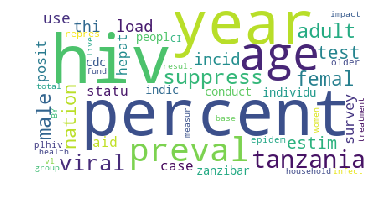

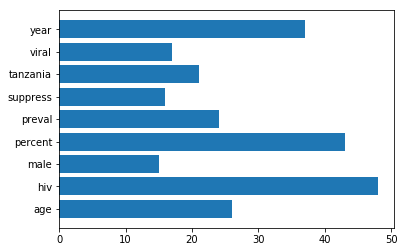

In [40]:
from nltk.stem import PorterStemmer

# stem tokens using the Porter Stemmer
stemmer = PorterStemmer()
stemmed_tokens = [stemmer.stem(token) for (token, tag) in tokens]

gen_wc_barh(stemmed_tokens)

*As a side note: stemming could be followed by a stem completion algorithm, which completes the stemmed words (e.g. "comput") to their meaningful counterparts (e.g. "computer"), based on a predefined completion dictionary.*

### Lemmatization
While stemming uses predetermined rules to get to the *stem* version of a word, [lemmatization](https://en.wikipedia.org/wiki/Lemmatisation) is based on a trained model and is aware of word *meanings*. For example: “are” and “be” will remain two different words after stemming, but will be changed into 'is' after the lemmatization proces. Still, a well-trained algorithm can distinguish between similar words with different meanings (e.g. 'viral' and 'virally'), so they are not combined during lemmatization.
For our lemmatization we are using the 'wordnet' model. When using this for the first time, you need to **download this model first**.


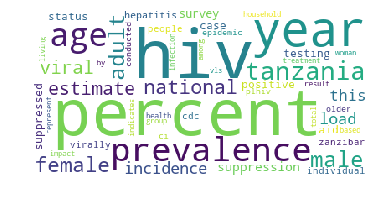

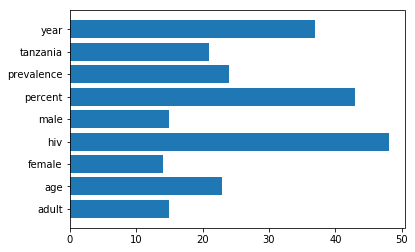

In [47]:
import nltk.stem.wordnet as wordnet
# nltk.download('wordnet')

# Lemmatize interesting tokens
lemmatizer = wordnet.WordNetLemmatizer()
lemmatized_tokens = [lemmatizer.lemmatize(token.lower()) for (token, tag) in tokens]
gen_wc_barh(lemmatized_tokens)


What are the main differences between these visuals and the previous ones? Which one is more useful?

## Named Entity Recognition
After al preprocessing steps, the fun *really* begins. Where POS tagging was limited to tag individual words only, [named entity recognition](https://en.wikipedia.org/wiki/Named-entity_recognition) is able to group multiple tokens into predefined categories, such as person names, locations, organizations, products, time... 
We'll give an example below:

In [3]:
chunked_sentences = nltk.ne_chunk_sents(tagged_sentences, binary=True)
# take a 'random' sentence
sentence = list(chunked_sentences)[-4]
print(sentence)
# You can get a more graphical drawing (will show up in a pop-up window)
#sentence.draw()

NameError: name 'nltk' is not defined

In the sentence above, you can recognize the found 'Named Entities' by the prefix `(NE`. We can now use the same wordcloud and bar chart visualizations to highlight the most frequent occurring named entities:

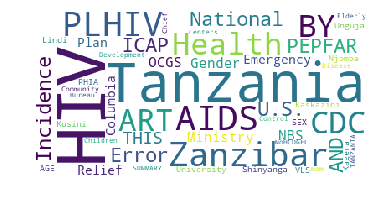

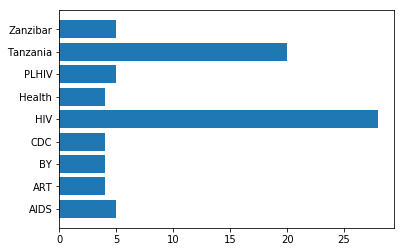

In [60]:
chunked_sentences = nltk.ne_chunk_sents(tagged_sentences, binary=True)
named_entities = [chunk.leaves() for sent in chunked_sentences for chunk in sent if hasattr(chunk, "label") and chunk.label() == "NE"]
NE_tokens = [token for leaves in named_entities for (token, tag) in leaves]

ctr = Counter(NE_tokens)
tokens, weights = zip(*ctr.most_common(9))

gen_wc_barh(NE_tokens)

## A classification example
### Using topic detection
So far, what you mainly have been doing, is a so called [bag-of-words analysis](https://en.wikipedia.org/wiki/Bag-of-words_model). This simplified model literally throws all words (or tokens, if you wish) of a document into a ‘bag’ and then looks for the most occurring ones. Now, we will do this for a range of multiple documents, categorizing topics for each document. As a result, you should be able to predict the topics of new, unseen documents.
For this, you will need to know about two more text mining techniques: *(i)* convert the bag of words to a [document-term-matrix** (DTM)**](https://en.wikipedia.org/wiki/Document-term_matrix) and *(ii)* the [latent Dirichlet allocation model **(LDA)**](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation). 

Simply put, A DTM is just another mathematical representation of multiple bag of word analyses, with rows corresponding to the documents in the collection and columns corresponding to the tokens. In Python, you can use the `CountVectorizer` package to create a DTM.
An LDA model is essentially used to discover topics in documents, based on a variety of variables, such as the number of topics, number of documents, probability and distribution of words, identity and weights of the words… The math behind the model is mind-boggling (have a look [here]( https://en.wikipedia.org/wiki/Dirichlet-multinomial_distribution). Luckily for us, calling the LDA model in Python is not that hard.

In [1]:
import os
import pandas as pd
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

txt_dir = r'..\output\medicine_txt'

file_name = []
input_text = []

# read all txt files (one time)
for curr_dir,_,filenames in os.walk(txt_dir):
    for filename in filenames:
        # filter to select only the pdfs that were converted using the 'simple' option
        if filename[:7] == 'simple_':
            # decode using the iso-8859 character set
            with open(os.path.join(curr_dir, filename), 'rt', encoding='8859') as file:
                txt_input = file.read()
                # consider only files with at least 100 characters
                if len(txt_input) > 99:
                    # strip '.txt' from the filename
                    file_name.append(filename[7:-4])
                    input_text.append(txt_input)

# store as pd.DataFrame
df = pd.DataFrame({'filename':file_name, 'text':input_text})


ModuleNotFoundError: No module named 'nltk'

In [13]:
# extract tokens
df['tokens'] = df['text'].apply(lambda txt: [nltk.word_tokenize(sent) for sent in nltk.sent_tokenize(txt)])

# POS-tagging
df['POS_tags'] = df['tokens'].apply(lambda tokens: [nltk.pos_tag(sent) for sent in tokens])

# split on tags
adj = ['JJ', 'JJR', 'JJS']
#df['adj'] = df['POS_tags'].apply(lambda tokens: [token for sent in tokens for (token, tag) in sent if tag in adj])
noun = ['NN', 'NNS', 'NNP', 'NNPS']
#df['noun'] = df['POS_tags'].apply(lambda tokens: [token for sent in tokens for (token, tag) in sent if tag in noun])
adverb = ['RB', 'RBR', 'RBS']
#df['adverb'] = df['POS_tags'].apply(lambda tokens: [token for sent in tokens for (token, tag) in sent if tag in adverb])
verb = ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
#df['verb'] = df['POS_tags'].apply(lambda tokens: [token for sent in tokens for (token, tag) in sent if tag in verb])
# select only tokens that were tagged as 'adjective', 'noun' or 'verb'.
df['i_tokens'] = df['POS_tags'].apply(lambda tokens: [token for sent in tokens for (token, tag) in sent if token.isalpha() and tag in adj + noun + verb])


In [14]:

# Create a document-term-matrix from the full text
tf_full_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
tf_full = tf_full_vectorizer.fit_transform(df['text'])
# Create a document-term-matrix from the selected tokens only
tf_segm_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
tf_segm = tf_segm_vectorizer.fit_transform(df['i_tokens'].apply(' '.join))

# init LDA to look for 3 topics
lda_full = LatentDirichletAllocation(n_components=3, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
# a second model for the segmented DTM
lda_segm = LatentDirichletAllocation(n_components=3, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
# fit the model and transform for results
lda_full_results = lda_full.fit_transform(tf_full)
lda_segm_results = lda_segm.fit_transform(tf_segm)

# read in a new file
txt_file = r'..\output\output_txt\guess_encoding.txt'
with open(txt_file, mode='rt', encoding='8859') as byte_file:
    new_text = byte_file.read()

# transform the new text to a doc-term-matrix
tf_full_new = tf_full_vectorizer.transform([new_text])
tf_segm_new = tf_segm_vectorizer.transform([new_text])
# and transform to discover associated topics
lda_full_new = lda_full.fit_transform(tf_full_new)
lda_segm_new = lda_segm.fit_transform(tf_segm_new)
print(lda_full_new)
print(lda_segm_new)

[[9.99044176e-01 4.77519428e-04 4.78304265e-04]]
[[5.23880665e-04 9.98948662e-01 5.27457711e-04]]


In [15]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()
    
print_top_words(lda_full, tf_full_vectorizer.get_feature_names(), 9)
print_top_words(lda_segm, tf_segm_vectorizer.get_feature_names(), 9)

Topic #0: hiv percent prevalence ages adults positive females males viral
Topic #1: heat extruhepatic 278 restless 920 cold bright cess fitting
Topic #2: hiv prevalence cm consultant csf suggesting hiring cases conventional

Topic #0: database sluggish restricts trisodium cytopenic lopinavir hiv prevalence macula
Topic #1: hiv percent prevalence adults ages positive females males viral
Topic #2: hiv percent adults ages prevalence positive mobility nfv epidemic



# Hier komt nog feedback op de gegeven topics?


## Other

Usefull libs:

- re
- gensim
- spaCy
- polyglot
- scikit-learn


Popular NL classifier:
- Naive-Bayes
